### Домашнее задание TSML-9 №2

1. Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
1. Приблизьте оба варианта моделями из класса MA.
1. Оцените качество и пришлите соображения, почему была выбрана та или иная модель.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline

In [2]:
def test_stationarity(name,timeseries):
    print(f'Results of Dickey-Fuller Test for {name}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dftest[1]#p-value

In [3]:
def tsplot(name, y, lags=None, figsize=(14, 8), style='bmh'):
    pval=test_stationarity(name,y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(f'{name}')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return pval

In [4]:
series_femalebirths = pd.read_csv("Series\daily-total-female-births-in-cal.csv")['Count'].dropna()
series_airline = pd.read_csv("Series\international-airline-passengers.csv")['Count'].dropna()
series_temperature = pd.read_csv("Series\mean-monthly-air-temperature-deg.csv")['Deg'].dropna()
#series_robberies = pd.read_csv("Series\monthly-boston-armed-robberies-j.csv")['Count'].dropna()
#series_sales= pd.read_csv("Series\monthly-sales-of-company-x-jan-6.csv")['Count'].dropna()
#series_dowjones = pd.read_csv("Series\weekly-closings-of-the-dowjones-.csv")['Close'].dropna()
series_femalebirths.head()

0    35
1    32
2    30
3    31
4    44
Name: Count, dtype: int64

In [5]:
lst_ser={'series_femalebirths':series_femalebirths
,'series_airline':series_airline
#,'series_temperature':series_temperature 
#,'series_robberies':series_robberies,
#'series_sales':series_sales,
#'series_dowjones':series_dowjones,
#'series_femalebirths':series_femalebirths
}

Results of Dickey-Fuller Test for series_femalebirths:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64
Гипотеза H0 о нестационарности series_femalebirths отвергается, так как P-value== 5.24E-05 < 5%
Results of Dickey-Fuller Test for series_airline:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Гипотеза H0 о нестационарности series_airline принимается, так как P-value== 9.92E-01 < 5%


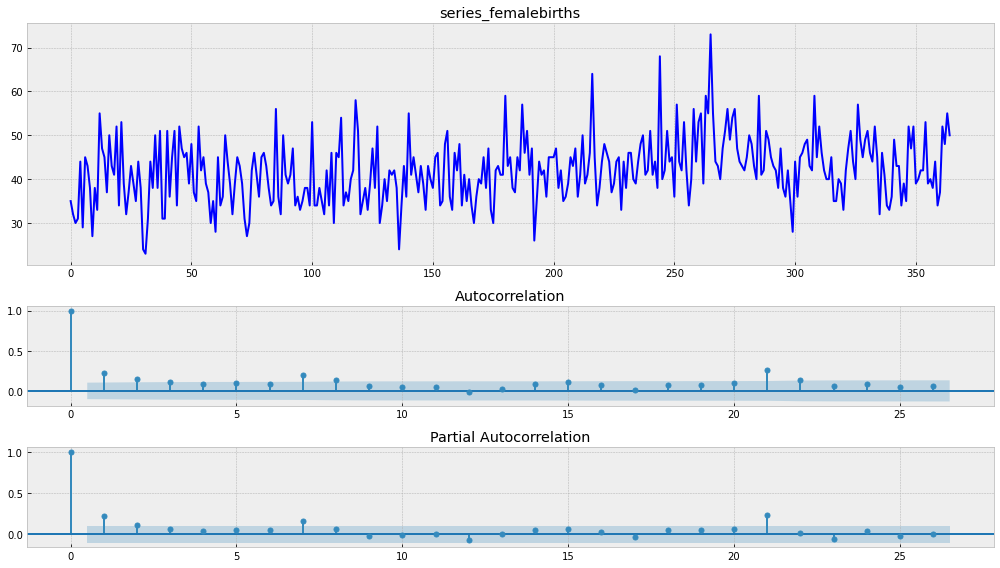

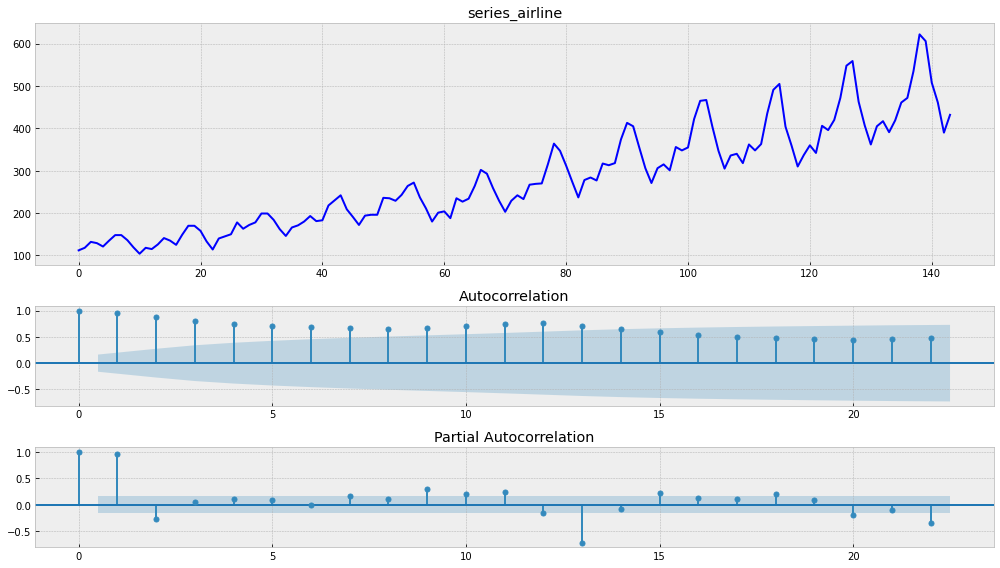

In [7]:
dct_ln={}
for k,ser in lst_ser.items():
    #ser_ln=np.log(ser)
    loc_p_v=tsplot(k,ser)
    if(loc_p_v<0.05):
        dct_ln[k]=ser
        print(f'Гипотеза H0 о нестационарности {k} отвергается, так как P-value=={loc_p_v : .2E} < 5%')
    else:
        print(f'Гипотеза H0 о нестационарности {k} принимается, так как P-value=={loc_p_v : .2E} < 5%')


Приблизим ряды series_femalebirths, series_airline при помощи WMA, EMA, DEMA, TEMA.

In [749]:
def weighted_ma(series, n, weights1, weights2, weights3, weights4, weights5, weights6, weights7, n_pred):
    weights = [weights1, weights2, weights3,
               weights4, weights5, weights6, weights7]
               

    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
        

    wma = series.rolling(n).apply(lambda s: (
        s * weights).sum() / weights.sum(), raw=True)
    wma[:6] = series[:n-1]

    new_series = wma[-n:].copy()
    for _ in range(n_pred):
        new_series = new_series.append((new_series.rolling(n).apply(lambda s: (
            s * weights).sum() / weights.sum(), raw=True)[-1:]), ignore_index=True)


    return wma.append(pd.Series(new_series), ignore_index=True), pd.Series(new_series)#new_series  #


In [750]:
def plot_wma(n=7, ser=series_airline, ser_to_plot=series_airline, n_preds=24, weights=[1,1,2,3,5,8,13]):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        ser,_ = weighted_ma(ser, n, weights[0], weights[1], weights[2], weights[3], weights[4], weights[5], weights[6], n_pred=n_preds)
        plt.plot(ser, color='red', linewidth='2', label='WMA {}'.format(weights[0]))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.legend()

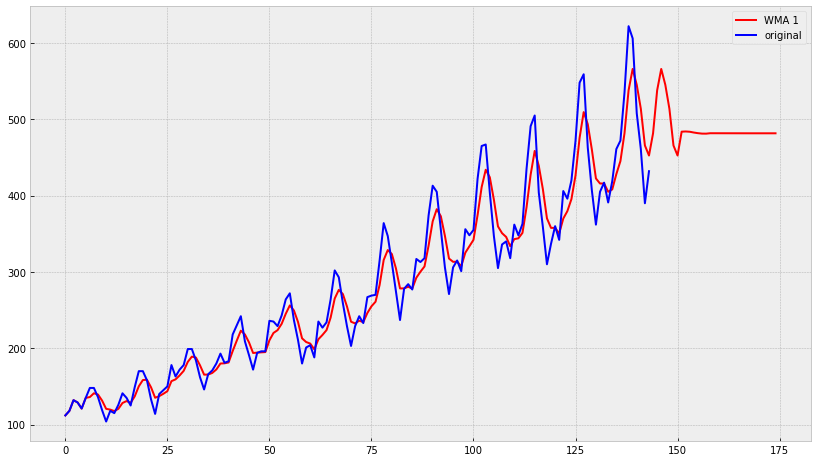

In [751]:
plot_wma()

In [666]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result)

In [719]:
#(alpha_opt, ser=train, ser_to_plot=series_airline, n_preds=len(val))
def plot_single_ema(alpha, ser=series_airline, ser_to_plot=series_airline, n_preds=24):
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        ser, _ = exponential_moving_average(ser, alpha, n_preds)
        plt.plot(ser_to_plot, color='blue',linewidth='4',label='original')
        plt.plot(ser, color='red', linewidth='2', label='EMA {}'.format(alpha))
        
        plt.legend()

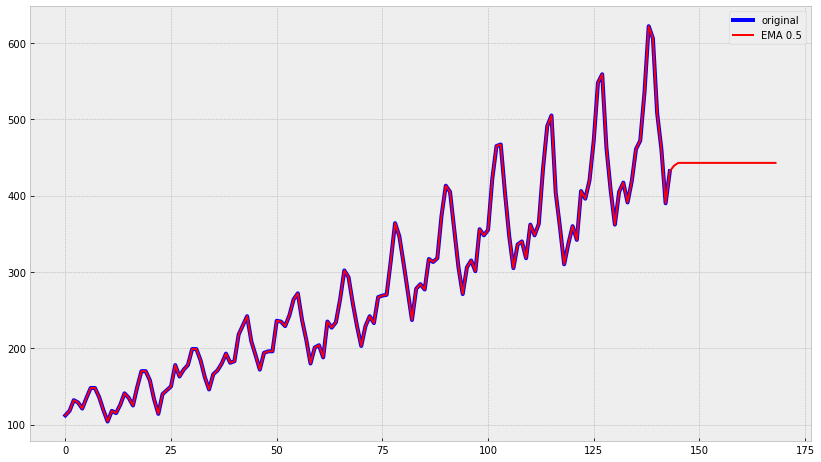

In [720]:
plot_single_ema(0.5)

In [674]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)

In [679]:

def plot_dema(alpha, beta, ser=series_airline, ser_to_plot=series_airline, n_preds=24):
    dema, _ = double_ema_with_preds(ser, alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue', linewidth='4', label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title(
            "Double_exponential_smoothing \n alpha={}, beta={}".format(alpha, beta))
        plt.legend()


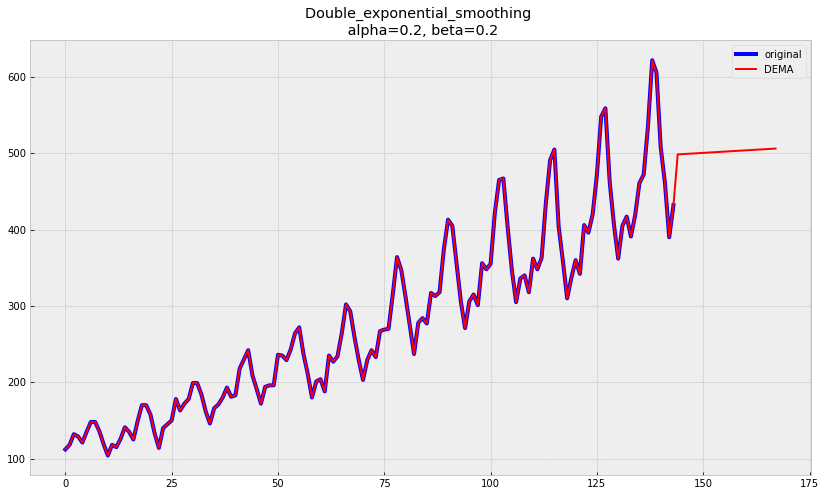

In [680]:
plot_dema(0.2,0.2)

In [537]:
def initial_trend(series, season_len):
    num_seasons = len(series)//season_len
    ser_trend = pd.Series([1,2])
    for i, s_v in enumerate(series):
        ser_trend[i] = (series[i+season_len]-series[i])/season_len
        num_seasons -= 1
        if num_seasons == 0:
            break

        
    num_seasons = len(series)//season_len
    return sum(ser_trend)/num_seasons


def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:  # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):  # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i % slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha * \
                (val-seasonals[i % slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i % slen] = gamma * \
                (val-smooth) + (1-gamma)*seasonals[i % slen]
            result.append(smooth+trend+seasonals[i % slen])
    return result


In [707]:
def plot_tema(alpha, beta, gamma, ser=series_airline, ser_to_plot=series_airline, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue', linewidth='4',label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("Triple_exponential_smoothing \n alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

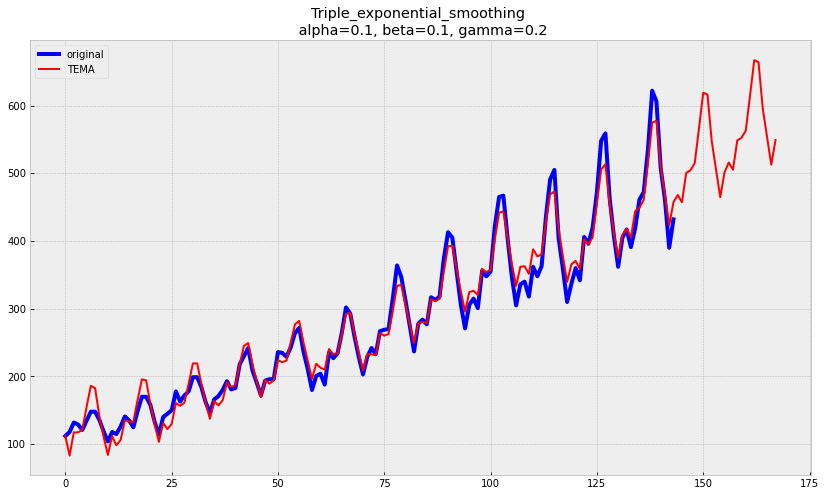

In [708]:
plot_tema(0.1, 0.1, 0.2)

In [736]:
#train, val = series_airline[:65], series_airline[65:]
dict_ma={'wma':0,'ema':0,'dema':0,'tema':0,}
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X,series,key):
    alpha, beta, gamma= X[:3]
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    weights1, weights2, weights3, weights4, weights5, weights6, weights7 = X
    #series =pd.Series(args[0])
    train, val = series[:65], series[65:]

    #print(type(series))
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        if key == dict_ma['tema']:
            result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        elif key == dict_ma['dema']:
            result,_ = double_ema_with_preds(series, alpha, beta, len(test_split))
        elif key == dict_ma['ema']:
            result,_ = exponential_moving_average(series, alpha, len(test_split))
        elif key == dict_ma['wma']:
            result = weighted_ma(series, 7, weights1, weights2, weights3, weights4, weights5, weights6, weights7, len(test_split))
        else:
            result = 0
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))

In [ ]:

opt_air_wma = minimize(mse_cross_val, x0=[0, 0, 1, 2, 3, 5, 8], args=(
    series_airline, dict_ma['wma']), method="Nelder-Mead", bounds=((0, 1), (0, 1), (1, 2), (2, 3), (3, 5), (5, 8), (8, 13)))


opt_fem_wma = minimize(mse_cross_val, x0=[0, 0, 1, 2, 3, 5, 8], args=(
    series_femalebirths, dict_ma['wma']), method="Nelder-Mead", bounds=((0, 1), (0, 1), (1, 2), (2, 3), (3, 5), (5, 8), (8, 13)))


# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))


In [ ]:

opt_air_ema = minimize(mse_cross_val, x0=[0, 0, 0, 0, 0, 0, 0], args=(
    series_airline, dict_ma['ema']), method="Nelder-Mead", bounds=((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)))


opt_fem_ema = minimize(mse_cross_val, x0=[0, 0, 0, 0, 0, 0, 0], args=(
    series_femalebirths, dict_ma['ema']), method="Nelder-Mead", bounds=((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)))


# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))


In [ ]:

opt_air_dema = minimize(mse_cross_val, x0=[0, 0, 0, 0, 0, 0, 0], args=(
    series_airline, dict_ma['dema']), method="Nelder-Mead", bounds=((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)))


opt_fem_dema = minimize(mse_cross_val, x0=[0, 0, 0, 0, 0, 0, 0], args=(
    series_femalebirths, dict_ma['dema']), method="Nelder-Mead", bounds=((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)))


# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))


In [ ]:

opt_air = minimize(mse_cross_val, x0=[0, 0, 0, 0, 0, 0, 0], args=(
    series_airline, dict_ma['tema']), method="Nelder-Mead", bounds=((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)))


opt_fem = minimize(mse_cross_val, x0=[0, 0, 0, 0, 0, 0, 0], args=(
    series_femalebirths, dict_ma['tema']), method="Nelder-Mead", bounds=((0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)))


# opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))


In [755]:
opt_fem_wma.x


array([ 7.13619925e-04,  2.47168663e+01,  8.46297756e-03,  9.43531180e+02,
       -7.29889491e+03, -2.08828855e+04, -5.81908092e+03])

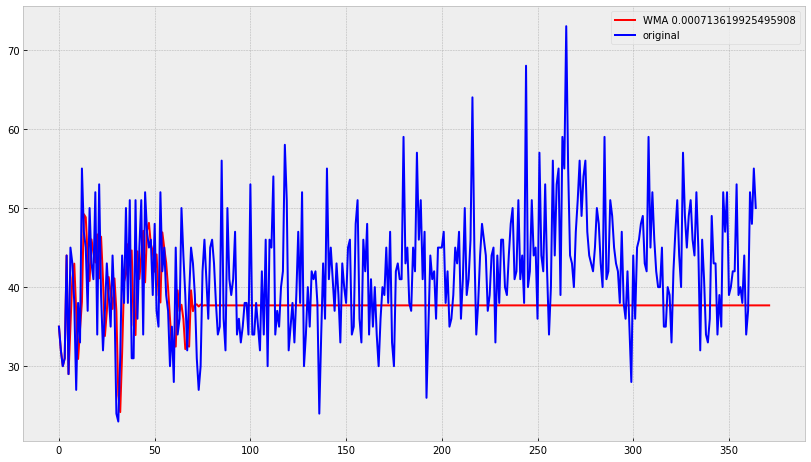

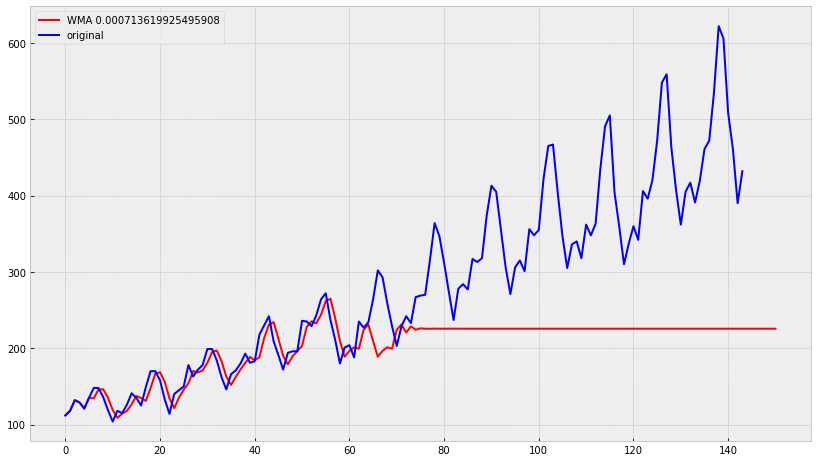

In [756]:
W = [x for x in opt_fem_wma.x]
train, val = series_femalebirths[:65], series_femalebirths[65:]

#plot_single_ema(alpha_opt, ser=train, ser_to_plot=series_femalebirths, n_preds=len(val))
plot_wma(n=7, ser=train, ser_to_plot=series_femalebirths, n_preds=len(val), weights=W)

W = [x for x in opt_fem_wma.x]
train, val = series_airline[:65], series_airline[65:]

#plot_single_ema(alpha_opt, ser=train, ser_to_plot=series_airline, n_preds=len(val))
plot_wma(n=7, ser=train, ser_to_plot=series_airline, n_preds=len(val), weights=W)

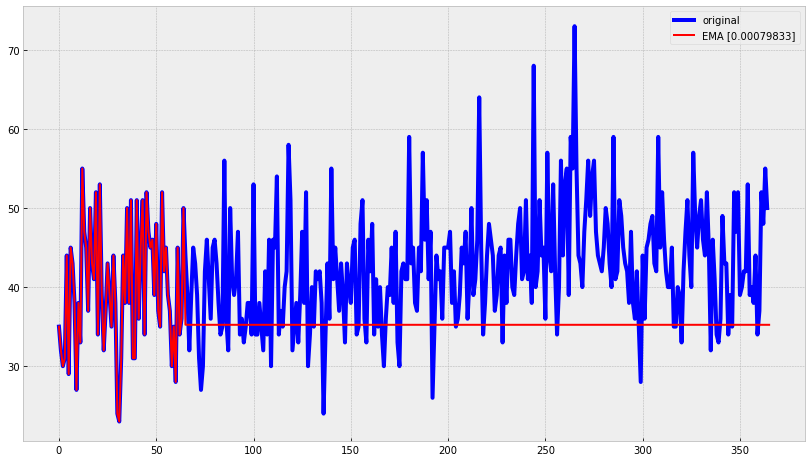

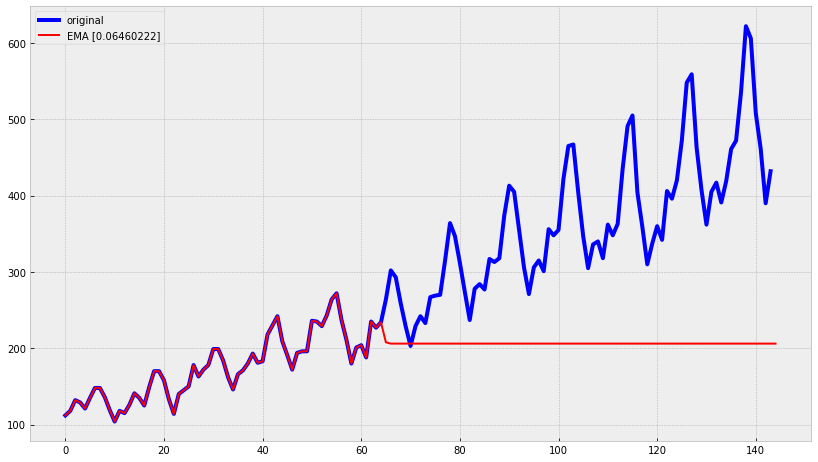

In [744]:
alpha_opt = opt_fem_ema.x[:1]
train, val = series_femalebirths[:65], series_femalebirths[65:]

plot_single_ema(alpha_opt, ser=train, ser_to_plot=series_femalebirths, n_preds=len(val))


alpha_opt = opt_air_ema.x[:1]
train, val = series_airline[:65], series_airline[65:]

plot_single_ema(alpha_opt, ser=train, ser_to_plot=series_airline, n_preds=len(val))

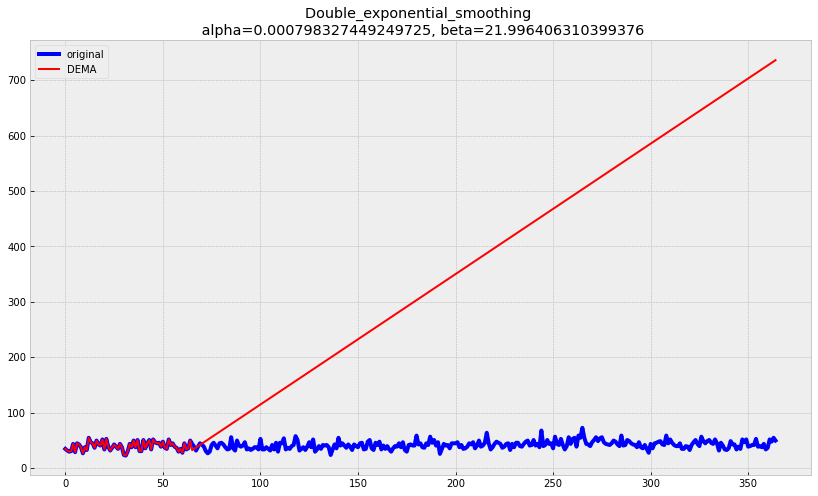

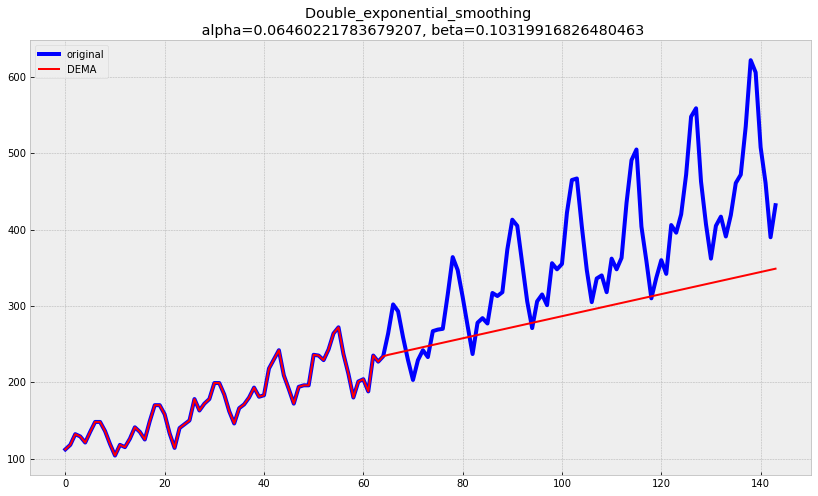

In [742]:
alpha_opt, beta_opt = opt_fem_dema.x[:2]
train, val = series_femalebirths[:65], series_femalebirths[65:]

plot_dema(alpha_opt, beta_opt, ser=train, ser_to_plot=series_femalebirths, n_preds=len(val))


alpha_opt, beta_opt = opt_air_dema.x[:2]
train, val = series_airline[:65], series_airline[65:]

plot_dema(alpha_opt, beta_opt, ser=train, ser_to_plot=series_airline, n_preds=len(val))

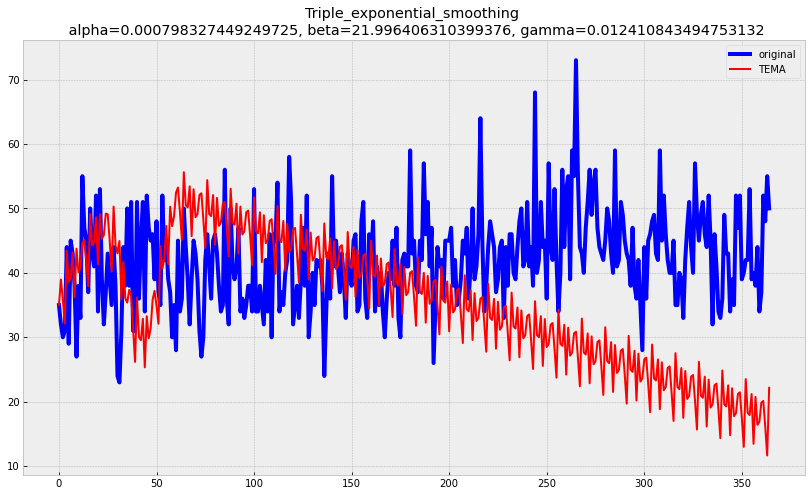

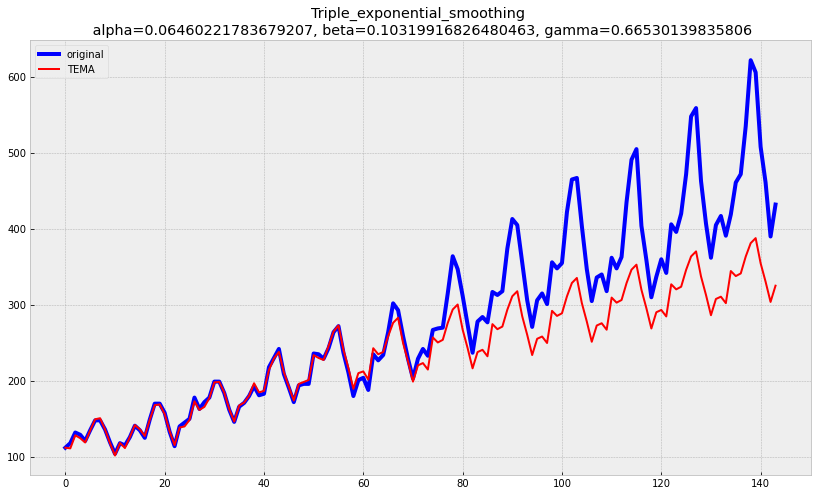

In [740]:
alpha_opt, beta_opt, gamma_opt = opt_fem.x[:3]
train, val = series_femalebirths[:65], series_femalebirths[65:]

plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series_femalebirths, n_preds=len(val))


alpha_opt, beta_opt, gamma_opt = opt_air.x[:3]
train, val = series_airline[:65], series_airline[65:]

plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series_airline, n_preds=len(val))

Выводы: Лучше всего предсказание временного ряда оказалось при помощи TEMA, при наличии сезонной составляющей.